In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Obróbka danych#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [ ]:
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis = 1, inplace = True)

In [ ]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season', 'mnth', 'holiday', 'weekday']
target = 'rentals'

In [ ]:
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp']) / bike_data['temp']
bike_data.drop(['atemp'], axis = 1, inplace = True)
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']

In [ ]:
cv = KFold(n_splits = 5, shuffle = False)

#Pierwszy model#

In [ ]:
X = bike_data[['temp']].copy()
y = bike_data[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Tworzymy Pipeline - najpierw tworzymy wielomian, następnie uczymy model
polynomial_regression_pipeline = make_pipeline(PolynomialFeatures(),
                                               LinearRegression())

# Nasz model sprawdzi te hiperparametry
params = {'polynomialfeatures__degree': [1, 2, 3, 4, 5]}

# Inicjalizujemy Pipeline
polynomial_regression_gridsearch = GridSearchCV(polynomial_regression_pipeline,
                                                params,
                                                scoring='neg_mean_squared_error', # wybrane będą takie hiperparametry, które dadzą najmniejszą wartość dla tego scoringu
                                                cv=cv)

# Uczymy Grid Search, podajemy X_train - Pipeline za nas zrobi wielomian :)
polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nNajlepsze hiperparametry:", polynomial_regression_gridsearch.best_params_, "\n")

# Przekazujemy najlepszy estymator
polynomial_regression_model = polynomial_regression_gridsearch.best_estimator_

#liczeenie metryk
predictions_train = polynomial_regression_model.predict(X_train)
predictions_test = polynomial_regression_model.predict(X_test)


Najlepsze hiperparametry: {'polynomialfeatures__degree': 3} 



#Ostatni model#

In [ ]:

# Podział na zmienne objaśniające i zmienną objaśnianą
Z = bike_data[numeric_features+categorical_features].copy()
w = bike_data[target].copy()

# Podział na zbiór treningowy i testowy (taki sam podział co poprzednio)
Z_train, Z_test, w_train, w_test = train_test_split(Z, w, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(Z_train, w_train)
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")

final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions_train2 = final_polynomial_regression_model.predict(Z_train)
predictions_test2 = final_polynomial_regression_model.predict(Z_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.947e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.8} 



#metryki obu modeli#

In [ ]:
print('#--pierwszy model--#')
print(' zbior treningowy')
print(f'Train R^2 {r2_score(y_train, predictions_train)}')
print(f'Train MAE {mean_absolute_error(y_train, predictions_train)}')
print(f'train MSE {mean_squared_error(y_train, predictions_train)}')
print(f'Train MAPE {mean_absolute_percentage_error(y_train, predictions_train)}')
print(f'Train RSME {sqrt(mean_squared_error(y_train, predictions_train))}')
print(' zbior testowy')
print(f'Test MAE {mean_absolute_error(y_test, predictions_test)}')
print(f'Test MSE {mean_squared_error(y_test, predictions_test)}')
print(f'Test MAPE {mean_absolute_percentage_error(y_test, predictions_test)}')
print(f'Test RSME {sqrt(mean_squared_error(y_test, predictions_test))} \n')
print('--opis--')
print(f'RMSE - MAE: {(sqrt(mean_squared_error(y_test, predictions_test))) - (mean_absolute_error(y_train, predictions_train))}')
print(' wartosc ta swiadczy o skali duzych problemow')
print(f'R^2: {r2_score(y_train, predictions_train)}')
print(' wartośc blizsza 1 jest dobrym modelem')
print(f'progres w nauce (test - train MAE): {(mean_absolute_error(y_test, predictions_test)) - (mean_absolute_error(y_train, predictions_train))}')
print(f' o {(mean_absolute_error(y_test, predictions_test)) - (mean_absolute_error(y_train, predictions_train))}  wartosci mniej sie pomyslił')
print(f'Procentowa pomylka modelu testowego w stosunku do modelu treningowego: \n {(mean_absolute_percentage_error(y_test, predictions_test)) - (mean_absolute_percentage_error(y_train, predictions_train))}')
print(f' model testowy pomylil sie wiecej o {((mean_absolute_percentage_error(y_test, predictions_test)) - (mean_absolute_percentage_error(y_train, predictions_train))) * 100}% \n')

print('#--drugi model--#')
print(' zbior treningowy')
print(f'Train R^2 {r2_score(y_train, predictions_train2)}')
print(f'Train MAE {mean_absolute_error(w_train, predictions_train2)}')
print(f'train MSE {mean_squared_error(w_train, predictions_train2)}')
print(f'Train MAPE {mean_absolute_percentage_error(w_train, predictions_train2)}')
print(f'Train RSME {sqrt(mean_squared_error(w_train, predictions_train2))}')
print(' zbior testowy')
print(f'Test MAE {mean_absolute_error(w_test, predictions_test2)}')
print(f'Test MSE {mean_squared_error(w_test, predictions_test2)}')
print(f'Test MAPE {mean_absolute_percentage_error(w_test, predictions_test2)}')
print(f'Test RSME {sqrt(mean_squared_error(w_test, predictions_test2))} \n')

print('--opis--')
print(f'RMSE - MAE: {(sqrt(mean_squared_error(w_test, predictions_test2))) - (mean_absolute_error(w_train, predictions_train2))}')
print(' wartosc ta swiadczy o skali duzych problemow')
print(f'R^2: {r2_score(y_train, predictions_train2)}')
print(' wartośc blizsza 1 jest dobrym modelem')
print(f'progres w nauce (test - train MAE): {(mean_absolute_error(w_test, predictions_test2)) - (mean_absolute_error(w_train, predictions_train2))}')
print(f' o {(mean_absolute_error(y_test, predictions_test2)) - (mean_absolute_error(w_train, predictions_train2))}  wartosci mniej sie pomyslił')
print(f'Procentowa pomylka modelu testowego w stosunku do modelu treningowego: \n {(mean_absolute_percentage_error(w_test, predictions_test2)) - (mean_absolute_percentage_error(w_train, predictions_train2))}')
print(f' model testowy pomylil sie wiecej o {((mean_absolute_percentage_error(w_test, predictions_test2)) - (mean_absolute_percentage_error(w_train, predictions_train2))) * 100}%')

print(' \n wnioski:')
print(f'procent pomyłek ostatniego do pierwszego: {-((mean_absolute_percentage_error(y_test, predictions_test))-(mean_absolute_percentage_error(w_test, predictions_test2)))*100}%')

#--pierwszy model--#
 zbior treningowy
Train R^2 0.3385254247551215
Train MAE 394.99380246760757
train MSE 302932.2416177629
Train MAPE 0.8491537777005765
Train RSME 550.3928066551769
 zbior testowy
Test MAE 389.0600774194398
Test MSE 370974.52423950454
Test MAPE 3.1036205434802304
Test RSME 609.076780249834 

--opis--
RMSE - MAE: 214.0829777822264
 wartosc ta swiadczy o skali duzych problemow
R^2: 0.3385254247551215
 wartośc blizsza 1 jest dobrym modelem
progres w nauce (test - train MAE): -5.933725048167787
 o -5.933725048167787  wartosci mniej sie pomyslił
Procentowa pomylka modelu testowego w stosunku do modelu treningowego: 
 2.2544667657796538
 model testowy pomylil sie wiecej o 225.44667657796538% 

#--drugi model--#
 zbior treningowy
Train R^2 0.6999640820376055
Train MAE 263.3407209150664
train MSE 137405.96629967765
Train MAPE 0.78867079201737
Train RSME 370.68310765352885
 zbior testowy
Test MAE 353.20862471195886
Test MSE 234159.5010243085
Test MAPE 1.2128369264040462
Test 

#Wnioski i metryki policzone#

#--pierwszy model--#
 zbior treningowy
- Train R^2 0.3385254247551215
- Train MAE 394.99380246760745
- train MSE 302932.2416177629
- Train MAPE 0.8491537777005753
- Train RSME 550.3928066551769

 zbior testowy
- Test MAE 389.0600774194397
- Test MSE 370974.5242395047
- Test MAPE 3.103620543480227
- Test RSME 609.0767802498341

--opis--

RMSE - MAE: 214.08297778222664
 - wartosc ta swiadczy o skali duzych problemow

R^2: 0.3385254247551215
 - wartośc blizsza 1 jest dobrym modelem

progres w nauce (test - train MAE): -5.93372504816773
 - o -5.93372504816773  wartosci mniej sie pomyslił

Procentowa pomylka modelu testowego w stosunku do modelu treningowego:
 - 2.2544667657796515
 , model testowy pomylil sie wiecej o 225.44667657796515%

#--drugi model--#
 zbior treningowy

- Train R^2 0.6999640820678186
- Train MAE 263.3407209155171
- train MSE 137405.96628584116
- Train MAPE 0.7886707926599182
- Train RSME 370.68310763486534

 zbior testowy

- Test MAE 353.208624894982
- Test MSE 234159.50124454123
- Test MAPE 1.2128369298607375
- Test RSME 483.90030093454294

--opis--

RMSE - MAE: 220.55958001902582
 - wartosc ta swiadczy o skali duzych problemow

R^2: 0.6999640820678186
 - wartośc blizsza 1 jest dobrym modelem

progres w nauce (test - train MAE): 89.86790397946487
 - o 89.86790397946487  wartosci mniej sie pomyslił

Procentowa pomylka modelu testowego w stosunku do modelu treningowego:
 - 0.4241661372008193,
 model testowy pomylil sie wiecej o 42.41661372008193%

#Wnioski:#
  Porównujac model pierwszego i ostatniego modelu regresji procent pomyłek w zbiorze testowym spadł o prawie 2 razy, dodatkowo mertyka R^2 była bliższa 1 co świadczyłoby o lepszym modelu

  Porównując metryki MAPE dla treningowego i testowego zestawu obu modeli możęmy zauważyć, że model drugi myli się tylko o 42% wiecej od testowego, a pierwszy myli się przy każdym razie, niski błąd zbioru testowego przekłada się na to, że nie mamy do czynienia ze zjawiskiem overfittingu jak w pierwszym modelu

#Ocena wizualna modelu#

In [ ]:
errors = predictions_test2 - w_test
errors1 = predictions_test - y_test

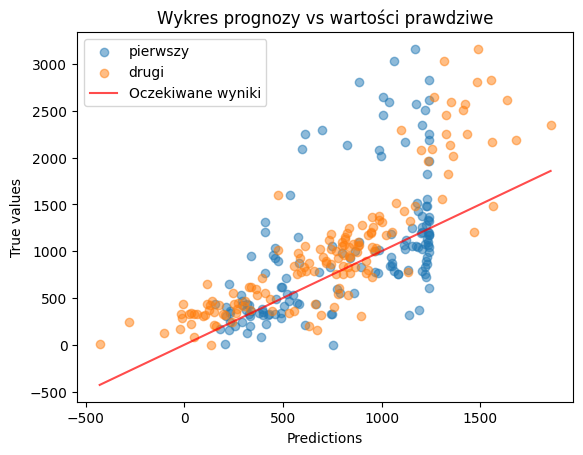

Jak widać model drugi o wiele lepiej odgaduje wartości z większą dokłądnością niż pierwszy, są lekkie odchyły przy większych wartościach, ale m,niej częste niż w pierwszym


In [ ]:
line_good = np.linspace(min(predictions_test2), max(predictions_test2), len(predictions_test2))

plt.scatter(x = predictions_test, y = y_test, alpha = 0.5, label = 'pierwszy')
plt.scatter(x = predictions_test2, y = w_test, alpha = 0.5, label = 'drugi')
plt.plot(line_good, line_good, color = 'r', alpha = 0.7, label = 'Oczekiwane wyniki')
plt.xlabel('Predictions')
plt.ylabel('True values')
plt.legend()
plt.title('Wykres prognozy vs wartości prawdziwe')
plt.show()

print('Jak widać model drugi o wiele lepiej odgaduje wartości z większą dokłądnością niż pierwszy, są lekkie odchyły przy większych wartościach, ale m,niej częste niż w pierwszym')

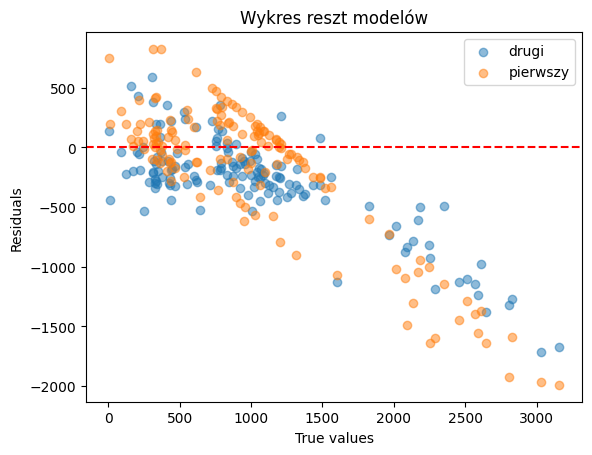

Wnioski: 
 Model drugi lepiej sobie radzi z wyższymi i niższymi wartościami prawdziwymi od modelu pierwszego


In [ ]:
plt.scatter(x = w_test, y = errors ,alpha = 0.5, label = 'drugi')
plt.xlabel('True values')
plt.ylabel('Residuals')
plt.axhline(0, color = 'r', linestyle = '--')
plt.scatter(x = y_test, y = errors1 ,alpha = 0.5, label = 'pierwszy')
plt.legend()
plt.title('Wykres reszt modelów')
plt.show()

print('Wnioski: \n Model drugi lepiej sobie radzi z wyższymi i niższymi wartościami prawdziwymi od modelu pierwszego')

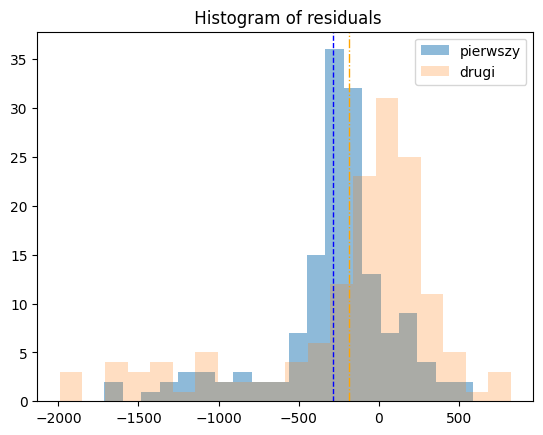

Dla drugiego error mean = -186.78269519561576
Dla pierwszego error mean = -282.24773144695615


In [ ]:
plt.hist(errors, bins = 20, label = 'pierwszy', alpha = 0.5)
plt.hist(errors1, bins = 20, label = 'drugi', alpha = 0.25)
plt.legend()
plt.axvline(errors.mean(), color = 'blue', linestyle = 'dashed', linewidth = 1)
plt.axvline(errors1.mean(), color = 'orange', linestyle = '-.', linewidth = 1)
plt.title(' Histogram of residuals')
plt.show()

print(f'Dla drugiego error mean = {errors1.mean()}')
print(f'Dla pierwszego error mean = {errors.mean()}')

Wnioski:  
1.   Jak widać drugi model ma średnią bliższą zeru przez co jest lepszy od pierwszego
2.   model drugi też posiada większą koncentrację blędów predykcji przy zerze c owskazuje, że sobie dobrze radzi z tymi danymi
3.   drugi też ma mniejszą szerokość zakresów przez co wskazuje, że ejgo przewidywania są bliższe rzeczywistości
4.   dodatkowo drugi posiada w miarę równo rozłożone wartości w około zera przez co można wnioskować, że daje sobie radę z równymi wartościami do przewidywania

